Reference - Faster R-CNN

The entire code for training a faster R-CNN was referred to from Kaggle. Orignally the code from kaggle was supposed to work on Fruits Images Dataset for fruit detection. We repuprosed the code to make it work with our Traffic Image Dataset in order to fine tune the Faster R-CNN model which has originally been trained on the COCO data set. 

The code can be found at this link:

https://www.kaggle.com/code/yerramvarun/fine-tuning-faster-rcnn-using-pytorch

The data set was obtained from this link:

https://www.kaggle.com/datasets/ashfakyeafi/road-vehicle-images-dataset

In [ ]:
# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [ ]:
ls

drive/  sample_data/


In [ ]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git

Cloning into 'vision'...
remote: Enumerating objects: 322860, done.
remote: Counting objects: 100% (845/845), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 322860 (delta 692), reused 817 (delta 674), pack-reused 322015
Receiving objects: 100% (322860/322860), 655.07 MiB | 24.09 MiB/s, done.
Resolving deltas: 100% (296745/296745), done.


In [ ]:
cd vision

/content/vision


In [ ]:
!git checkout v0.3.0

Note: switching to 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at be376084d8 version check against PyTorch's CUDA version


In [ ]:
cd ../

/content


In [ ]:
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

In [ ]:
!pip install pycocotools --quiet

In [ ]:
# Basic python and ML Libraries
import os, sys
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
ROOT_DIR = '/'
sys.path.insert(0, ROOT_DIR)
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

ModuleNotFoundError: ignored

In [ ]:
ls

coco_eval.py   drive/     __pycache__/  transforms.py  vision/
coco_utils.py  engine.py  sample_data/  utils.py


In [ ]:
# defining the files directory and testing directory
files_dir = 'drive/MyDrive/train'
test_dir = '../input/fruit-images-for-object-detection/test_zip/test'


class FruitImagesDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.jpg']
        
        
        # classes: 0 index is reserved for background
        self.classes = [_, 'vehicle','bike']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        # annotation file
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)


# check dataset
dataset = FruitImagesDataset(files_dir, 640, 640)
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[78]
print(img.shape, '\n',target)

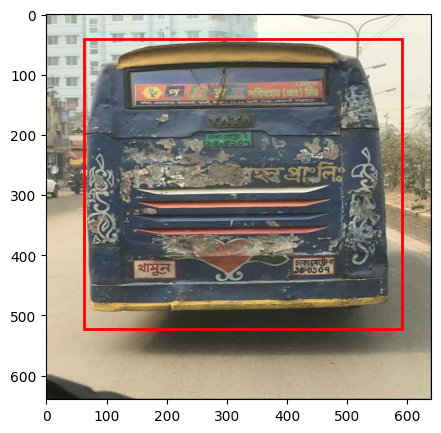

In [ ]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[25]
plot_img_bbox(img, target)

In [ ]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [ ]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
# use our dataset and defined transformations
dataset = FruitImagesDataset(files_dir, 640, 640, transforms= get_transform(train=True))
dataset_test = FruitImagesDataset(files_dir, 640, 640, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [ ]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print(device)

num_classes = 3

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.00001,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=500,
                                               gamma=0.1)

cuda


In [ ]:
# training for 10 epochs
num_epochs = 20

i = 1
for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    if i%5 == 0:
      evaluate(model, data_loader_test, device=device)
    i+=1

Epoch: [0]  [   0/2161]  eta: 0:24:32  lr: 0.000000  loss: 1.2957 (1.2957)  loss_classifier: 0.7688 (0.7688)  loss_box_reg: 0.4899 (0.4899)  loss_objectness: 0.0356 (0.0356)  loss_rpn_box_reg: 0.0015 (0.0015)  time: 0.6815  data: 0.4267  max mem: 8928
Epoch: [0]  [ 100/2161]  eta: 0:07:13  lr: 0.000001  loss: 1.7978 (1.4603)  loss_classifier: 0.8124 (0.7529)  loss_box_reg: 0.8069 (0.5975)  loss_objectness: 0.0530 (0.0554)  loss_rpn_box_reg: 0.0267 (0.0545)  time: 0.2067  data: 0.0062  max mem: 8928
Epoch: [0]  [ 200/2161]  eta: 0:06:53  lr: 0.000002  loss: 1.3032 (1.4575)  loss_classifier: 0.6872 (0.7241)  loss_box_reg: 0.5520 (0.5901)  loss_objectness: 0.0261 (0.0803)  loss_rpn_box_reg: 0.0124 (0.0630)  time: 0.2147  data: 0.0083  max mem: 8928
Epoch: [0]  [ 300/2161]  eta: 0:06:32  lr: 0.000003  loss: 1.4136 (1.3982)  loss_classifier: 0.6253 (0.6844)  loss_box_reg: 0.5949 (0.5690)  loss_objectness: 0.0284 (0.0813)  loss_rpn_box_reg: 0.0226 (0.0636)  time: 0.2066  data: 0.0059  max me

In [ ]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [ ]:
# pick one image from the test set
img, target = dataset_test[11]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  77
real #boxes:  11


EXPECTED OUTPUT


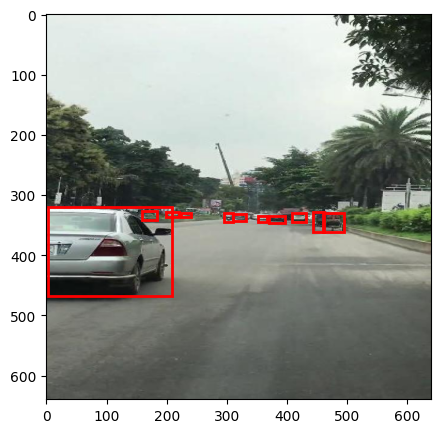

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

MODEL OUTPUT


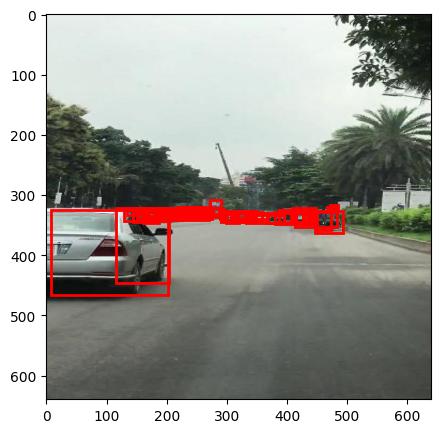

In [ ]:
print('MODEL OUTPUT')
tmp_prediction = {}
tmp_prediction['boxes'] = prediction['boxes'].cpu()
tmp_prediction['labels'] = prediction['labels'].cpu()
tmp_prediction['scores'] = prediction['scores'].cpu()

plot_img_bbox(torch_to_pil(img), tmp_prediction)

NMS APPLIED MODEL OUTPUT
14


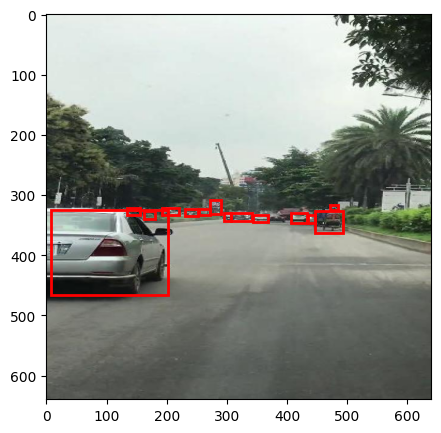

In [ ]:
nms_prediction = apply_nms(tmp_prediction, iou_thresh=0.01)
print('NMS APPLIED MODEL OUTPUT')
print(len(nms_prediction['labels']))
plot_img_bbox(torch_to_pil(img), nms_prediction)

In [ ]:
test_dirs = 'drive/MyDrive/test_poster'

test_dataset = FruitImagesDataset(test_dirs, 640, 640, transforms= get_transform(train=False))
# pick one image from the test set
img, target = test_dataset[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

final_prediction = {}
final_prediction['boxes'] = nms_prediction['boxes'].cpu()
final_prediction['labels'] = nms_prediction['labels'].cpu()
final_prediction['scores'] = nms_prediction['scores'].cpu()

plot_img_bbox(torch_to_pil(img), final_prediction)

NameError: ignored